###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

A softmax regressor training using graphs

### Imports and preparing training/test data

In [1]:
import numpy as np
from graphs.core import Param
from graphs.core import DataHolder
from graphs.core import Graph
from graphs.nodes import linear_node
from graphs.nodes import bias_node
from graphs.nodes import softmax_node
from graphs.nodes import mce_node
from graphs.optimizers import AdamOptimizer
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import pathlib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Do not modify or delete this!
def plot_boundary(h_node,X_node,
                  X_train,y_train,X_test,y_test,
                  poly=None,scaler=None,xlim=(0,1),ylim=(0,1)):
    # Creates an auxiliary graph
    graph = Graph()
    graph.build(h_node)
    # Generates mesh
    pts = 100
    x1 = np.linspace(xlim[0], xlim[1], pts)  # x1
    x2 = np.linspace(ylim[0], ylim[1], pts)  # x2
    x1, x2 = np.meshgrid(x1, x2)
    mesh = np.vstack((x1.flatten(), x2.flatten())).T
    if poly is not None:
        mesh = poly.transform(mesh)
    if scaler is not None:
        mesh = scaler.transform(mesh)    
    # Training set
    if scaler is not None:
        temp = scaler.inverse_transform(X_train)
    plt.scatter(temp[:,0],temp[:,1],cmap='viridis',c=y_train.flatten(),s=50,edgecolor='k')
    # Boundary
    graph.feed({X_node: mesh})
    graph.forward()
    h = h_node.value
    indexes = set(range(h.shape[1]))
    for i in indexes:
        g = h[:,i] - h[:,list(indexes - {i})].max(axis=1)
        plt.contour(x1, x2, g.reshape((pts,pts)), levels = [0], colors='black')
    # Decision regions
    y_pred = h.argmax(axis=1).reshape((pts,pts))
    plt.contourf(x1, x2, y_pred, alpha = 0.10,cmap='viridis')
    # Test set
    graph.feed({X_node: X_test})
    graph.forward()
    y_pred = h_node.value.argmax(axis=1)
    correct = (y_pred == y_test.flatten())
    if scaler is not None:
        temp = scaler.inverse_transform(X_test)
    plt.scatter(temp[correct,0],temp[correct,1], marker='.', c='black', s=60)
    plt.scatter(temp[~correct,0],temp[~correct,1], marker='x', c='black', s=60)

In [3]:
# Loads dataset
dataset = datasets.load_iris()
features = [1,2]
predictors = dataset['data'][:,features]
responses = dataset['target'].reshape(-1,1)

In [4]:
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,responses,stratify=responses)
# Expand dataset to include polynomial features
ps = PolynomialFeatures(degree = 7,include_bias=False)
ps.fit(X_train)
X_train = ps.transform(X_train)
X_test = ps.transform(X_test)
# Standarize dataset
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Creating custom computational graph
Here we use our custom toy implemenations and perform training by minimizing the output of the graph (the loss/cost function).

In [5]:
# Builds models inputs and params
_,d = X_train.shape
n = len(np.unique(y_train))
X_node = DataHolder()
y_node = DataHolder()

In [6]:
# Builds model connections
w_node = Param((d,n))
b_node = Param((1,n))
r_node = linear_node(X_node,w_node)
z_node = bias_node(r_node,b_node)
h_node = softmax_node(z_node)
J_node = mce_node(h_node,y_node)

In [7]:
# Graph helper object
graph = Graph()
graph.build(J_node).initialize()

In [8]:
# Computing the accuracy of the model with random weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Accuracy (Training): ', '%.2f'  % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f'  % accuracy_score(y_test, y_pred))

Accuracy (Training):  0.37
Accuracy (Test):  0.34


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: No contour levels were found within the data range.


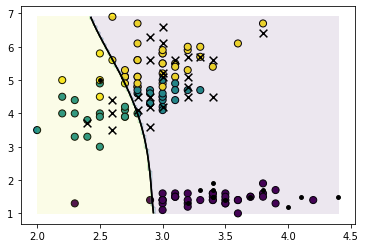

In [9]:
# Plots boundary
plot_boundary(J_node.inputs[0].inputs[0], X_node,
              X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

In [10]:
# Training
niter,history = graph.minimize(optimizer=AdamOptimizer())
print('In {:} iteration cost went from {:} to {:}'.format(niter,history[0],history[-1]))

In 1000 iteration cost went from 61.86036825180236 to 0.1417963223141183


In [11]:
# Computing the accuracy of the model with trained weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Accuracy (Training): ', '%.2f'  % accuracy_score(y_train, y_pred))
graph.feed(feeder={X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f'  % accuracy_score(y_test, y_pred))

Accuracy (Training):  0.94
Accuracy (Test):  1.00


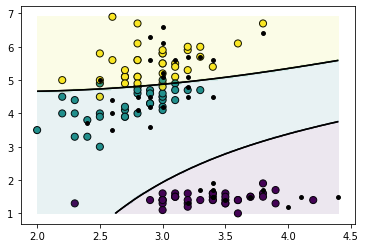

In [12]:
# Plots boundary
plot_boundary(J_node.inputs[0].inputs[0], X_node,
              X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

### Building tensorflow graph
Here we use tensorflow to create the same computational graph and perform training by minimizing the output of the graph (the loss/cost function).

In [13]:
class SoftmaxGraph:
    def __init__(self, categories, features):
        self.weights = tf.Variable(tf.random.uniform((features, categories), dtype=tf.float32))
        self.bias = tf.Variable(tf.random.uniform((1, categories), dtype=tf.float32))
        self.optimizer = tf.keras.optimizers.Adam()
    
    def predict(self, inputs):
        outputs = tf.nn.softmax(
            tf.add(tf.matmul(inputs, self.weights), self.bias)
        )
        return outputs
    
    def step(self, inputs, outputs):
        logits = tf.add(tf.matmul(inputs, self.weights), self.bias)
        loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits,
            labels=tf.cast(outputs, dtype=tf.int64)
        ))
        return loss
    
    def minimize(self, inputs, outputs):
        for epoch in range(1000):
            with tf.GradientTape() as tape:
                loss = self.step(inputs, outputs)
            gradients = tape.gradient(loss, [self.bias, self.weights])
            self.optimizer.apply_gradients(zip(gradients, [self.bias, self.weights]))

In [14]:
model = SoftmaxGraph(categories=3, features=X_train.shape[1])

In [15]:
# Computing the accuracy of the model with random weights and bias
inputs = tf.convert_to_tensor(X_train, dtype=tf.float32)
outputs = model.predict(inputs)
y_pred = outputs.numpy().argmax(axis=1)
print('Accuracy (Training): ', '%.2f'  % accuracy_score(y_train, y_pred))
inputs = tf.convert_to_tensor(X_test, dtype=tf.float32)
outputs = model.predict(inputs)
y_pred = outputs.numpy().argmax(axis=1)
print('Accuracy (Test): ', '%.2f'  % accuracy_score(y_test, y_pred))

Accuracy (Training):  0.25
Accuracy (Test):  0.21


In [16]:
# Prepares inputs/outputs for training
inputs = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_true = tf.convert_to_tensor(y_train.ravel(), dtype=tf.float32)

In [17]:
# Workaround to be able to trace
@tf.function()
def build_model(inputs, outputs):
    model.step(inputs, outputs)

In [18]:
# Set up logging.
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = pathlib.Path('logs/%s' % stamp)
writer = tf.summary.create_file_writer(str(logdir))
tf.summary.trace_on(graph=True, profiler=False)
# Call only one tf.function when tracing.
outputs = build_model(inputs, y_true)
# Stores to file
with writer.as_default():
    tf.summary.trace_export(name="build_model_trace", step=0, profiler_outdir=str(logdir))

In [19]:
# Training
model.minimize(inputs, y_true)

In [20]:
# Computing the accuracy of the model with trained weights and bias
inputs = tf.convert_to_tensor(X_train, dtype=tf.float32)
outputs = model.predict(inputs)
y_pred = outputs.numpy().argmax(axis=1)
print('Accuracy (Training): ', '%.2f'  % accuracy_score(y_train, y_pred))
inputs = tf.convert_to_tensor(X_test, dtype=tf.float32)
outputs = model.predict(inputs)
y_pred = outputs.numpy().argmax(axis=1)
print('Accuracy (Test): ', '%.2f'  % accuracy_score(y_test, y_pred))

Accuracy (Training):  0.94
Accuracy (Test):  1.00
